<a href="https://colab.research.google.com/github/anampavicic/SGAI-Final-Project/blob/main/final_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02805 Social Graphs and Interactions, Fall 2024

## Project Assignment B

Group members:
 - Ana Marija Pavicic (s232468)
 - Inês	Da Fonseca Tacanho (s232669)
 - Raquel Moleiro Marques (s243636)

#### Imports

In [2]:
import re
import os
import sys
import math
import nltk
import json
# import torch
import urllib
import pickle
import statistics
import unicodedata
import numpy as np
import pandas as pd
import polars as pl
from tqdm import tqdm
import seaborn as sns
import networkx as nx
import tensorflow as tf
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from scipy.stats import pearsonr
from nltk.corpus import stopwords
import cartopy.feature as cfeature
from fa2_modified import ForceAtlas2
from traceback import format_exception
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from scipy.stats import percentileofscore
from sklearn.preprocessing import MinMaxScaler
from cartopy.io.shapereader import natural_earth
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt_tab')

2024-12-08 13:48:54.740977: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Get Cities Data From The Airports Dataset

In [4]:
file_path = 'data/airports.csv'
airports = pd.read_csv(file_path)

# Extract unique cities from the 'City' column
print(f"Number of unique cities in the dataset: {len(set(airports['City']))}")

# Create dictionary with IATA as key and City as value
# Note that IATA stands for International Air Transport Association airport code
airport_city_dict = airports.set_index('IATA')['City'].to_dict()

# remove nan values
airport_city_dict = {key: value for key, value in airport_city_dict.items() if not pd.isna(value)}

print(f"Number of unique IATA codes in the dataset: {len(airport_city_dict.keys())}")

Number of unique cities in the dataset: 6956
Number of unique IATA codes in the dataset: 6034


## Get Connections From Flight Route Dataset

In [5]:
file_path = 'data/routes.csv'
routes = pd.read_csv(file_path)

# Filter rows where stops == 0
direct_flights = routes[routes['Stops'] == 0]

# Making sure that we are extracting the right data
# Extract source airports and destination airports from direct flights
source_airports_set = set(direct_flights['Source Airport'])
dest_airports_set = set(direct_flights['Destination Airport'])

# Extract the set of airports that have corresponding cities from the airport_city_dict
airports_set = set(airport_city_dict.keys())

# Find the intersection between destination airports from direct flights and airports with cities
combined_airports = dest_airports_set.intersection(airports_set)

print(f"Number of airports that are in both direct flights and have city data: {len(combined_airports)}")

Number of airports that are in both direct flights and have city data: 3254


## Creating a Directed Graph of Direct Flights

In [6]:
G = nx.DiGraph()

for index, row in direct_flights.iterrows():
   # get airport code
   source_airport = row['Source Airport']
   destination_airport = row['Destination Airport']
   airline = row['Airline']
   airline_id = row['Airline ID']

   # Check if the airport codes exist in the dictionary
   if source_airport in airport_city_dict and destination_airport in airport_city_dict:
      # Get city names based on airport codes
      source_city = airport_city_dict[source_airport]
      destination_city = airport_city_dict[destination_airport]

       # Check if the edge already exists
      if G.has_edge(source_city, destination_city):
         # Increment the weight attribute
         G[source_city][destination_city]['weight'] += 1
      else:
         # Add a new edge with weight = 1 and other attributes
         G.add_edge(source_city, destination_city, weight=1, Airline=airline, Airline_ID=airline_id)

print(f"The directed network has {len(G.nodes())} nodes and {len(G.edges())} edges")

The directed network has 3135 nodes and 34610 edges


### Edge Weight Distribution of Directed Graph

In [7]:
# Extract edge weights from the graph
edge_weights = [data['weight'] for _, _, data in G.edges(data=True)]

# Count occurrences of each weight
weight_distribution = Counter(edge_weights)

# Print the edge weight distribution
print("Edge Weight Distribution:")
for weight, count in weight_distribution.items():
    print(f"Weight {weight}: {count} edges")

Edge Weight Distribution:
Weight 1: 18663 edges
Weight 2: 8526 edges
Weight 6: 470 edges
Weight 5: 882 edges
Weight 3: 3691 edges
Weight 4: 1665 edges
Weight 7: 267 edges
Weight 8: 171 edges
Weight 9: 94 edges
Weight 11: 30 edges
Weight 14: 13 edges
Weight 12: 37 edges
Weight 10: 65 edges
Weight 13: 13 edges
Weight 25: 1 edges
Weight 15: 10 edges
Weight 17: 6 edges
Weight 24: 1 edges
Weight 16: 4 edges
Weight 18: 1 edges


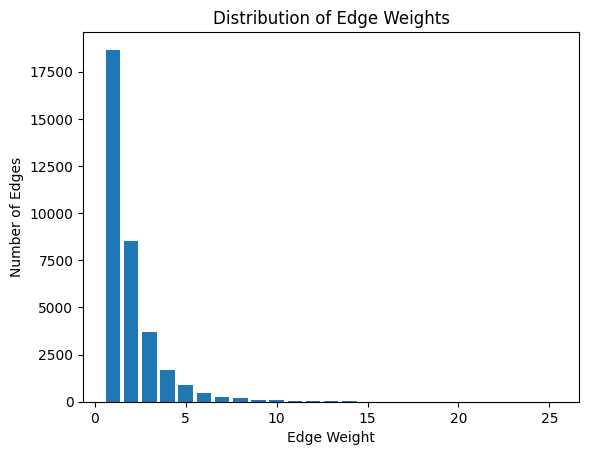

In [8]:
# Visualize the edge weight distribution
plt.bar(weight_distribution.keys(), weight_distribution.values())
plt.xlabel('Edge Weight')
plt.ylabel('Number of Edges')
plt.title('Distribution of Edge Weights')
plt.show()

## Turn the Directed Graph into Undirected

In [9]:
G_undirected = nx.Graph()

# Iterate through all edges in the directed graph G
for u, v, data in G.edges(data=True):
    weight = data['weight']  # Get the weight (number of flights)

    # If the edge already exists in the undirected graph, sum the weights
    if G_undirected.has_edge(u, v):
        G_undirected[u][v]['weight'] += weight
    else:
        # Otherwise, add the edge with the initial weight
        G_undirected.add_edge(u, v, weight=weight)

# Find the largest connected component
largest_component = sorted(nx.connected_components(G_undirected), key=len, reverse=True)
# Create a subgraph from the largest component
G_largest = G_undirected.subgraph(largest_component[0])

# Display the number of nodes and edges in the undirected graph
print(f"The undirected graph has {len(G_largest.nodes())} nodes and {len(G_largest.edges())} edges")

The undirected graph has 3129 nodes and 17690 edges


## Add Latitude and Longitude to nodes for vizualization :)

In [10]:
# Create a mutable copy of the frozen graph
G = nx.Graph(G_largest)

# List to store nodes without matching coordinates
nodes_to_remove = []

for node in list(G.nodes()):
    # Filter the DataFrame for matching city
    matched_rows = airports.loc[airports['City'] == node, ['Latitude', 'Longitude']]

    if not matched_rows.empty:
        # Extract latitude and longitude if a match is found
        lat, lon = matched_rows.values[0]
        G.nodes[node]['coords'] = (lon, lat)
    else:
        # Add the node to the removal list
        print(f"Coordinates not found for node: {node}")
        nodes_to_remove.append(node)

# Remove nodes that do not have matching coordinates
G.remove_nodes_from(nodes_to_remove)

print(f"Removed {len(nodes_to_remove)} nodes without coordinates.")
print(f"Remaining nodes in graph: {len(G.nodes())}")

Removed 0 nodes without coordinates.
Remaining nodes in graph: 3129


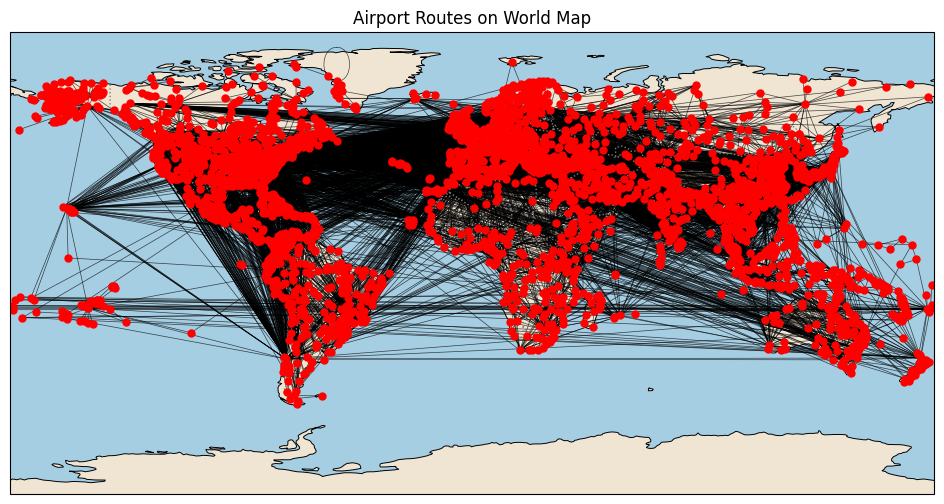

In [11]:
positions = {node: data['coords'] for node, data in G.nodes(data=True)}

# Set up the map using Cartopy
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Enhanced map styling
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Add detailed features
ax.add_feature(cfeature.LAND, facecolor="#f0e4d3")  # Light beige for land
ax.add_feature(cfeature.OCEAN, facecolor="#a6cee3")  # Light blue for oceans
ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=0.7)
ax.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="gray")

# Draw the graph
nx.draw_networkx_edges(G, positions, ax=ax, edge_color='black', alpha=0.7, width=0.5)
nx.draw_networkx_nodes(G, positions, ax=ax, node_size=25, node_color='red')

# Show the plot
plt.title("Airport Routes on World Map")
plt.show()

### Saving and loading the graph to pickle

In [12]:
# Save the graph to a file using pickle
with open('flight_network_graph.pickle', 'wb') as f:
   pickle.dump(G, f)

In [13]:
# Load the graph from the pickle file
with open('flight_network_graph.pickle', 'rb') as f:
   G = pickle.load(f)

## Scrape City Information from Wikipedia
### Helper functinos

In [14]:
def get_wikipedia_page(name):
  """
  Fetch the Wikipedia page for a given city name using the Wikipedia API.
  Returns the raw JSON data from the query response.
  """

  baseurl = "https://en.wikipedia.org/w/api.php?"
  action = "action=query"
  urltitle = f"titles={name}" # City name to query
  content = "prop=revisions&rvprop=content&rvslots=main"
  dataformat ="format=json"

  query = f"{baseurl}{action}&{urltitle}&{content}&{dataformat}"

  # Send the query request to the Wikimedia API and get the response
  wikiresponse = urllib.request.urlopen(query)
  wikidata = wikiresponse.read()
  wikitext = wikidata.decode('utf-8')
  data = json.loads(wikitext)
  return data

def get_wikitext_content(data):
   """
    Extracts the content (wikicode) from the API response.
    Traverses the data structure to find and return the actual content.
    """
   if isinstance(data, dict):
      for key, value in data.items():
         if key == '*':
               return value
         result = get_wikitext_content(value)
         if result:
               return result
   elif isinstance(data, list):
      for item in data:
         result = get_wikitext_content(item)
         if result:
               return result
   return None

def clean_city_name (city_name):
  """
  Cleans the city name by replacing spaces with underscores and encoding it for URL use.
  """
  cleaned_name = str(city_name).replace(" ", "_") # Replace spaces with underscores
  cleaned_name = urllib.parse.quote(cleaned_name) # URL encode the city name
  return cleaned_name

def get_content(name):
  """
  Retrieves the content for a given city name by cleaning the name, fetching the Wikipedia page,
  and extracting the content.
  """
  city = clean_city_name(name) # Clean and prepare the city name
  data = get_wikipedia_page(city) # Get the page data
  content = get_wikitext_content(data) # Extract the content from the page data
  return content

def redirect (content):
  """
  This funciton redirect to the right page in case there is a need
  """
  if content is not None and "#REDIRECT" in content.upper():
    # get the redirect link
    matches = re.findall(r'\[\[(.*?)\]\]', content)
    redirect_name = matches[0]
    content = get_content(redirect_name)

  return content

def may_refer_to_city(content):
  """
  In case there are more pages with the same name get the first one that matches either city or capital or town
  """
  if content is not None and len(content) < 6000 and ("may refer to" in content.lower() or "refers to" in content.lower()):
    matches = re.findall(r'\[\[(.*?)\]\](?=.*\b(capital|city|town)\b)', content)
    if len(matches) > 0:
      name = matches[0]
      content = get_content(name)
      content = redirect(content)
  return content

## Fetching Wikipedia Content for Cities

In [ ]:
# Running this code takes 20 minutes on colab and a LOT on perconal PC
not_found_content = []

output_dir = "./new_cities"
os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists

# Iterate through the nodes with a progress bar
for node in tqdm(G.nodes(), desc="Processing nodes", unit="node"):

    try:
        file_name = node + ".txt"
        output_file = os.path.join(output_dir, file_name)
        # Try to fetch the Wikipedia page and get the content
        content = get_content(node)

        # chech for redirect
        content = redirect(content)

        # chech to may refer to
        content = may_refer_to_city(content)

        # in case content is not found or is to small (it is assumed that in that case the conetent is irrelevant)
        if content is None or len(content) < 6000:
          not_found_content.append(node)
        else:
            with open(output_file, 'w', encoding='utf-8') as file:
                file.write(content)

    except Exception as e:
        not_found_content.append(node)
        # If an error occurs, print the error message and the node
        print(f"Failed to get content for node {node}: {e}")
        continue  # Continue to the next node if there's an error


Processing nodes: 100%|██████████| 3129/3129 [20:54<00:00,  2.49node/s] 


In [ ]:
print(len(not_found_content))

880


## Extract and clean History and Demography from the Wikipedia Scrapped Files
#### Helper functions

In [15]:
def find_history(wiki_content):
   # Search for a section titled "History" in the wiki content
   match = re.search(r'==\s*History\s*==([\s\S]*?)(?=\n==[^=]+==)', wiki_content)
   if match:
      history_text = match.group(1).strip()  # Extract the matched text and strip leading/trailing whitespace
      return history_text
   else:
      return None

def find_demography(wiki_content):
   # Search for a section titled "Demography" in the wiki content
   match = re.search(r'==\s*Demography\s*==([\s\S]*?)(?=\n==[^=]+==)', wiki_content)
   if match:
      history_text = match.group(1).strip()  # Extract the matched text and strip leading/trailing whitespace
      return history_text
   else:
      return find_demographics(wiki_content)

def find_demographics(wiki_content):
   # Search for a section titled "Demographics" in the wiki content
   match = re.search(r'==\s*Demographics\s*==([\s\S]*?)(?=\n==[^=]+==)', wiki_content)
   if match:
      history_text = match.group(1).strip()  # Extract the matched text and strip leading/trailing whitespace
      return history_text
   else:
      return None

def remove_nested_braces(text):
   # Stack to track opening braces and a list for the result
   stack = []
   result = []
   i = 0

   while i < len(text):
      # Check for opening {{, push to stack when found
      if text[i:i+2] == "{{":
         if len(stack) == 0:  # Only start removing when we find the outermost {{
               result.append('')  # Start ignoring text within the outer block
         stack.append("{{")  # Push opening '{{' to stack
         i += 2  # Skip past the opening '{{'

      # Check for closing }}, pop from stack when found
      elif text[i:i+2] == "}}":
         if stack:
               stack.pop()  # Pop from the stack when closing '}}' is found
         if len(stack) == 0:  # When we reach the outermost closing '}}'
               result.append('')  # Add empty string to remove content
         i += 2  # Skip past the closing '}}'

      # If we are outside any {{}} block, add the character to the result
      else:
         if not stack:
               result.append(text[i])  # Only add text if not inside a {{}} block
         i += 1  # Move to the next character

   return ''.join(result)

def clean_text(text):
   # Use regular expressions to clean unwanted patterns

   # Remove all occurrences of the pattern [[File: ... ]] including any nested content inside
   # This handles image file references that might appear in wiki-style text
   text = re.sub(r'\[\[File:[^\[\]]*(?:\[\[[^\[\]]*\]\][^\[\]]*)*\]\]', '', text) # file remove, nested

   # Replace any occurrence of [[...]] with just the inner text (removes the brackets)
   text = re.sub(r'\[\[(.*?)\]\]', r'\1', text)
   text = remove_nested_braces(text)

   # Remove any content wrapped in {{...}} (likely templates)
   text = re.sub(r'{{(.*?)}}', '', text, flags=re.DOTALL)

   # Remove any reference tags <ref>...</ref> which are used for citations in wiki-style texts
   text = re.sub(r'<ref.*?>.*?</ref>', '', text, flags=re.DOTALL)

   # Remove any gallery tags <gallery>...</gallery>, typically used for images in wiki content
   text = re.sub(r'<gallery.*?>.*?</gallery>', '', text, flags=re.DOTALL)

   return text.strip()

### Extract and clean Historical and Demographical Content from Files

In [16]:
# Specify source and destination directories
source_dir = 'new_cities/'
history_destination_dir = 'history/'
demography_destination_dir = 'demography/'

# Create the destination directory if it doesn't exist
os.makedirs(history_destination_dir, exist_ok=True)
os.makedirs(demography_destination_dir, exist_ok=True)

# Iterate over the files in the source directory
count_history = 0
count_demography = 0
for filename in os.listdir(source_dir):
   # define reading and writting paths
   source_path = os.path.join(source_dir, filename)
   history_destination_path = os.path.join(history_destination_dir, filename)
   demography_destination_path = os.path.join(demography_destination_dir, filename)

   # Check if it's a file (not a directory)
   if os.path.isfile(source_path):
      # Open the file in read mode and read its content
      with open(source_path, 'r', encoding='utf-8') as file:
         file_content = file.read()

      # extract histroy
      history = find_history(file_content)
      if history is not None:
         # clean the history
         history = clean_text(history)

         # count succesfull
         count_history += 1
         with open(history_destination_path, "w", encoding="utf-8") as file_history:
            file_history.write(history)

      # extract demography
      demography = find_demography(file_content)
      if demography is not None:
         # clean the demography
         demography = clean_text(demography)

         # count succesfull
         count_demography += 1
         with open(demography_destination_path, "w", encoding="utf-8") as file_demography:
            file_demography.write(demography)

   else:
      print(f"Skipped (not a file): {source_path}")

print("File transfer complete!")
print("Successfully extracted history:", count_history)
print("Successfully extracted demogrraphy:", count_demography)

File transfer complete!
Successfully extracted history: 1955
Successfully extracted demogrraphy: 1355


### Add population data to check for correlations

In [ ]:
# Load the graph from the pickle file
with open('flight_network_graph.pickle', 'rb') as f:
   G = pickle.load(f)

In [ ]:
df = pd.read_csv('worldcities.csv')
print(df)

In [ ]:
# Function to normalize city names
def normalize_city_name(city_name):
    # Replace common abbreviations like 'St' with 'Saint'
    city_name = re.sub(r'\bSt\b', 'Saint', city_name, flags=re.IGNORECASE)

    # Remove hyphens and other non-alphanumeric characters
    city_name = re.sub(r'[^a-zA-Z0-9]', '', city_name)

    # Remove accents and convert to lowercase
    city_name = unicodedata.normalize('NFKD', city_name).encode('ASCII', 'ignore').decode('ASCII')

    # Convert to lowercase to ensure case-insensitivity
    city_name = city_name.lower()

    return city_name

# Function to add population as integers to the graph
def add_population_to_graph(graph, city_df):
    # Ensure the DataFrame has no missing values in the matching column
    city_df = city_df[~city_df['city_ascii'].isnull()]

    # Normalize the graph node names (ensure the city names in the graph are also standardized)
    normalized_nodes = {normalize_city_name(node): node for node in graph.nodes}

    # Iterate through the DataFrame
    for _, row in city_df.iterrows():
        city = row['city_ascii']
        population = row['population']

        # Normalize the city name
        normalized_city = normalize_city_name(city)

        # Convert population to integer if it is not null
        if not pd.isnull(population):
            population = int(population)

        # Check if the normalized city name exists in the graph nodes
        if normalized_city in normalized_nodes:
            # Add population as a node attribute
            nx.set_node_attributes(graph, {normalized_nodes[normalized_city]: {'population': population}})

    return graph

G = add_population_to_graph(G, df)

for node, data in G.nodes(data=True):
    print(f"Node: {node}, Data: {data}")

In [ ]:
# List of nodes without population data
missing_population_nodes = [node for node, data in G.nodes(data=True) if data.get('population') in (None, 0)]
print(f"Number of nodes without population data: {len(missing_population_nodes)}")

In [ ]:
# TODO: I think the below isnt going to go though since now we are
    # separating history and demography data from new_cities file ??

def check_missing_nodes_in_new_cities(missing_population_nodes, city_files_path):
    # List to store cities that have corresponding files
    cities_with_files = []

    # Get all filenames in the directory (without the full path)
    city_files = os.listdir(city_files_path)

    # Loop through each city in missing_population_nodes
    for city in missing_population_nodes:
        # Normalize city name for filename search (optional step, depending on naming convention)
        normalized_city = normalize_city_name(city)

        # Create potential filenames based on the city name variations
        filenames_to_check = [
            f"{normalized_city}.txt",  # Normalized version
            f"{city}.txt"              # Original name version (if filenames are unnormalized)
        ]

        # Check if any of the filenames exist in the directory
        for filename in filenames_to_check:
            if filename in city_files:
                cities_with_files.append(city)
                break  # If one of the filenames matches, no need to check further variations
        else:
            print(f"File for {city} not found.")

    # Print the results
    print(f"\nCities with corresponding files in '{city_files_path}':")
    for city in cities_with_files:
        print(f"- {city}")

    return cities_with_files

city_files_path = './new_cities'

# Check which cities have corresponding files in the new_cities folder
cities_with_files = check_missing_nodes_in_new_cities(missing_population_nodes, city_files_path)

#### Get population data for the ones that are not in the dataset but in scrapped files

In [ ]:
def normalize_city_name(city_name):
    # Add your own normalization logic, if needed (e.g., converting to lowercase, removing spaces)
    return city_name.strip().lower()

def extract_population_urban(content):
    # Updated regex to handle both commas and periods in population_urban values
    match = re.search(r'population_urban\s*=\s*([0-9.,]+)', content)
    if match:
        population_str = match.group(1)

        # Remove any non-numeric characters (like <ref>, whitespace, etc.)
        population_str = re.sub(r'[^\d.,]', '', population_str)

        # Replace period (.) as thousands separator (convert to commas)
        if '.' in population_str and ',' in population_str:
            population_str = population_str.replace('.', '')  # remove periods
        else:
            # If it only has periods and no commas, treat it as a thousands separator
            population_str = population_str.replace('.', '')

        # Now the population_str should contain only digits and commas
        # Remove commas, convert to integer
        population_str = population_str.replace(',', '')  # Remove commas for integer conversion

        try:
            return int(population_str)
        except ValueError:
            # If the conversion fails, return None (invalid format)
            return None
    return None

def check_population_urban_in_city_files(cities_with_files, city_files_path):
    city_population_urban = {}  # Dictionary to store city and corresponding population_urban

    for city in cities_with_files:
        # Normalize city name for filename search
        normalized_city = normalize_city_name(city)

        # Create potential filenames to check for the city
        filenames_to_check = [
            f"{normalized_city}.txt",  # Normalized version
            f"{city}.txt"              # Original name version
        ]

        # Check the files for population_urban
        found_population_urban = False

        for filename in filenames_to_check:
            file_path = os.path.join(city_files_path, filename)
            if os.path.exists(file_path):
                with open(file_path, 'r') as file:
                    content = file.read()

                    # Extract population_urban if present
                    population_urban = extract_population_urban(content)
                    if population_urban is not None:
                        city_population_urban[city] = population_urban
                        print(f"Population urban data found for {city} in file: {filename} - Population Urban: {population_urban}")
                        found_population_urban = True
                        break  # Once population_urban is found, no need to check further filenames

        if not found_population_urban:
          pass
            #print(f"Population urban data not found for {city}.")

    return city_population_urban  # Return the dictionary containing city and population_urban

In [ ]:
def add_population_urban_to_graph(graph, city_population_urban):
    # Normalize all graph nodes to match city names
    normalized_nodes = {normalize_city_name(node): node for node in graph.nodes}

    for city, population_urban in city_population_urban.items():
        # Normalize the city name from the city_population_urban dictionary
        normalized_city = normalize_city_name(city)
        # Check if the normalized city name exists in the normalized nodes of the graph
        if normalized_city in normalized_nodes:
            original_node_name = normalized_nodes[normalized_city]

            # Add population_urban as a node attribute using the original (non-normalized) node name
            nx.set_node_attributes(graph, {original_node_name: {'population': population_urban}})
            print(f"Added population urban for {original_node_name}: {population_urban}")
        else:
            print(f"Node for {city} not found in the graph.")

    return graph

In [ ]:
city_population_urban = check_population_urban_in_city_files(cities_with_files, city_files_path)

if city_population_urban:
    G = add_population_urban_to_graph(G, city_population_urban)

    # Verify the updated graph
    for node, data in G.nodes(data=True):
        print(f"Node: {node}, Data: {data}")
else:
    print("No population urban data found to update the graph.")

In [ ]:
# List of nodes without population data
missing_population_nodes = [node for node, data in G.nodes(data=True) if data.get('population') in (None, 0)]
print(f"Number of nodes without population data: {len(missing_population_nodes)}")

### Population correlations

In [ ]:
# Calculate centrality measures
degree_centrality = nx.degree_centrality(G)

# Create a list of nodes that have population data
nodes_with_population = [node for node, data in G.nodes(data=True) if 'population' in data]

# Now filter out centrality values only for nodes that have population data
filtered_degree_centrality = {node: degree_centrality[node] for node in nodes_with_population}

# Create a population list for the nodes with population data
filtered_population_values = [G.nodes[node]['population'] for node in nodes_with_population]

In [ ]:
# Normalize population values using MinMaxScaler
scaler = MinMaxScaler()
normalized_population_values = scaler.fit_transform([[pop] for pop in filtered_population_values])

# Now, map back to the nodes
normalized_population_dict = dict(zip(nodes_with_population, normalized_population_values.flatten()))

In [ ]:
# Filter out nodes where population or centrality is NaN or infinite
valid_nodes = [
    node for node in nodes_with_population
    if not np.isnan(normalized_population_dict[node]) and np.isfinite(normalized_population_dict[node])
    and not np.isnan(filtered_degree_centrality[node]) and np.isfinite(filtered_degree_centrality[node])
]

# Re-filter the centrality values and populations for valid nodes
filtered_population_values = [normalized_population_dict[node] for node in valid_nodes]
filtered_degree_values = [filtered_degree_centrality[node] for node in valid_nodes]
filtered_degree_values2 = [G.degree(node) for node in valid_nodes]  # Use raw degree instead of centrality

# Ensure all lists are of the same length (no missing values)
assert len(filtered_population_values) == len(filtered_degree_values)

In [ ]:
# Get edge weights for the graph (assuming the graph has 'weight' attribute on edges)
edge_weights = {}
for node in valid_nodes:
    total_edge_weight = 0

    # Sum the weights of the edges connected to the node
    for neighbor in G.neighbors(node):
        if 'weight' in G[node][neighbor]:  # Check if weight attribute exists
            total_edge_weight += G[node][neighbor]['weight']

    # Store the total weight for the node
    edge_weights[node] = total_edge_weight

# List of edge weights corresponding to valid nodes
filtered_edge_weights = [edge_weights[node] for node in valid_nodes]

# Ensure no NaN or infinite values in edge weights and population data
filtered_population_values = [pop for pop, weight in zip(filtered_population_values, filtered_edge_weights) if not np.isnan(weight) and np.isfinite(weight)]
filtered_edge_weights = [weight for weight in filtered_edge_weights if not np.isnan(weight) and np.isfinite(weight)]

In [ ]:
# Calculate Pearson correlation between population and centrality measures
degree_corr, _ = pearsonr(filtered_population_values, filtered_degree_values)
degree_corr2, _ = pearsonr(filtered_population_values, filtered_degree_values2)
edge_weight_corr, _ = pearsonr(filtered_population_values, filtered_edge_weights)

print(f"Correlation between population and degree centrality: {degree_corr}")
print(f"Correlation between population and degree: {degree_corr2}")
print(f"Correlation between population and sum of edge weights: {edge_weight_corr}")

In [ ]:
sns.set(style="whitegrid")

# Scatter plot for population vs. degree
plt.figure(figsize=(8, 6))
plt.scatter(filtered_population_values, filtered_degree_values2, color='blue', label='Degree')
sns.regplot(x=filtered_population_values, y=filtered_degree_values2, scatter=False, color='blue', line_kws={'color': 'blue'})
plt.xlabel('Normalized Population')
plt.ylabel('Degree')
plt.title('Population vs. Degree')
plt.show()

# Scatter plot for population vs. degree centrality
plt.figure(figsize=(8, 6))
plt.scatter(filtered_population_values, filtered_degree_values, color='blue', label='Degree Centrality')
sns.regplot(x=filtered_population_values, y=filtered_degree_values, scatter=False, color='blue', line_kws={'color': 'blue'})
plt.xlabel('Normalized Population')
plt.ylabel('Degree Centrality')
plt.title('Population vs. Degree Centrality')
plt.show()

# Scatter plot for population vs. edge weights
plt.figure(figsize=(8, 6))
plt.scatter(filtered_population_values, filtered_edge_weights, color='purple', label='Edge Weights')
sns.regplot(x=filtered_population_values, y=filtered_edge_weights, scatter=False, color='purple', line_kws={'color': 'purple'})
plt.xlabel('Normalized Population')
plt.ylabel('Sum of Edge Weights')
plt.title('Population vs. Sum of Edge Weights')
plt.show()

## Combining History and Demographics text into dataframe for graph creation

In [18]:
# Initialize an empty DataFrame with the required columns and explicit types
text_df = pl.DataFrame({
    "node": pl.Series([], dtype=pl.Utf8),
    "combined_text": pl.Series([], dtype=pl.Utf8)
})

# Process files in the `history` folder
for filename in os.listdir('history'):
    filename_wo_txt = os.path.splitext(filename)[0]
    if filename_wo_txt in G.nodes():
        with open(os.path.join('history', filename), 'r', encoding='utf-8') as file:
            content = file.read()
        new_row = pl.DataFrame({"node": [filename_wo_txt], "combined_text": [content]})
        text_df = pl.concat([text_df, new_row], how="vertical", rechunk=True)

# Process files in the `demography` folder
for filename in os.listdir('demography'):
    filename_wo_txt = os.path.splitext(filename)[0]
    if filename_wo_txt in G.nodes():
        with open(os.path.join('demography', filename), 'r', encoding='utf-8') as file:
            content = file.read()
        new_row = pl.DataFrame({"node": [filename_wo_txt], "combined_text": [content]})
        text_df = pl.concat([text_df, new_row], how="vertical", rechunk=True)

# Combine rows for the same `node` into a single row with concatenated text
nodes = text_df["node"].unique()
aggregated_data = []

for node in nodes:
    node_data = text_df.filter(text_df["node"] == node)
    combined_text = " ".join(node_data["combined_text"].drop_nulls().to_list())
    aggregated_data.append({"node": node, "combined_text": combined_text})

# Create the final DataFrame
text_df = pl.DataFrame(aggregated_data)


## Get subgraph of fligths network with text content

In [101]:
cities = text_df['node'].to_list()

G_flights_sub = G.copy()
print("Before creating subgraph")
print(len(list(G_flights_sub.nodes())))
print(len(list(G_flights_sub.edges())))

# List to store nodes to remove
nodes_to_remove = []

for node in G_flights_sub.nodes():
    if node not in cities:
        nodes_to_remove.append(node)

# Remove nodes that do not have history
G_flights_sub.remove_nodes_from(nodes_to_remove)
print("After creating subgraph")
print(len(list(G_flights_sub.nodes())))
print(len(list(G_flights_sub.edges())))

Before creating subgraph
3129
17690
After creating subgraph
2039
12557


In [68]:
with open('G_flights_sub.pickle', 'wb') as f:
    pickle.dump(G_flights_sub, f)

## Prepare Data

In [22]:
# get all the tokens that refer to the same genre
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
#stop_words.update(['http','title', 'short', 'description', ' ', 'wa'])

city_history_dict = {}
for row in text_df.iter_rows(named=True):
    city = row["node"]
    city_text = row["combined_text"]

    # Tokenize text
    tokens = word_tokenize(city_text)
    # Convert to lowercase and remove punctuation
    tokens = [word.lower() for word in tokens if word.isalnum()]
    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # remove single characters
    tokens = [word for word in tokens if len(word) > 1]

    content = " ".join(tokens)
    city_history_dict[city] = content

## City Text Analysis with TFIDF and Cosine Similarity

In [23]:
# Calculate TF-IDF for each genre
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(city_history_dict.values())
feature_names = tfidf_vectorizer.get_feature_names_out()

In [24]:
# Extract the list of cities (nodes) from the 'node' column in the history_df dataframe
cities = text_df['node'].to_list()

# Compute the cosine similarity matrix for the TF-IDF matrix
cosine_sim_matrix = cosine_similarity(tfidf_matrix)

# Create a dataframe to store the cosine similarities
cosine_similarities_tfidf = pd.DataFrame(cosine_sim_matrix, index=cities, columns=cities)

In [25]:
print("Mean: ", cosine_similarities_tfidf.mean().mean())
'''print(f'{cosine_similarities_dslim.mean().idxmax()} is the city with the most similarities with an average of {cosine_similarities_dslim.mean().max()}')
print(f'{cosine_similarities_dslim.mean().idxmin()} is the city with the least similarities with an average of {cosine_similarities_dslim.mean().min()}')
'''
print("Max: ", cosine_similarities_tfidf.mean().max())
print("Min: ", cosine_similarities_tfidf.mean().min())
print("Median: ", cosine_similarities_tfidf.mean().median())
print("Std: ", cosine_similarities_tfidf.mean().std())

Mean:  0.03134838419354553
Max:  0.08991851812365094
Min:  0.0
Median:  0.030000949155989828
Std:  0.011843228786954072


## City Text Analysis with LDA and Cosine Similarity

In [26]:
#find number of subsections in text file
def find_all_sections(wiki_content):
    # Match any section with = signs (e.g., ===Section===) and its content
    pattern = r'(={2,}\s*[^=\n]+\s*={2,})([\s\S]*?)(?=\n={2,}[^=]+=*|\Z)'
    matches = re.findall(pattern, wiki_content)

    # Extract section headers and their content into a dictionary
    sections = {}
    for header, content in matches:
        # Clean the header of excess = signs and whitespace
        clean_header = re.sub(r'^={2,}\s*|\s*={2,}$', '', header).strip()
        sections[clean_header] = content.strip()

    return sections

In [27]:
sub_sections = {}
# Get subsection count of each city
for city in cities:
    text = " ".join(text_df.filter(text_df["node"] == city)["combined_text"].to_list())
    sections = find_all_sections(text)
    sub_sections[city] = len(sections)

# Get mean
mean_sub_sections = round(sum(sub_sections.values()) / len(sub_sections))
print(f"Mean number of subsections per city: {mean_sub_sections}")

Mean number of subsections per city: 3


In [28]:
# Initialize the CountVectorizer
vectorizer = CountVectorizer()

# Apply the vectorizer to the city history text data to create a term frequency matrix
tf = vectorizer.fit_transform(city_history_dict.values())

# Initialize the Latent Dirichlet Allocation (LDA) model to extract 10 topics
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(tf)

topics = lda.components_  # Word distributions per topic

# Transform the term frequency matrix to get the topic distribution for each city
city_topics = lda.transform(tf)

In [29]:
# Compute cosine_similarity for LDA
cosine_similarities_lda = cosine_similarity(city_topics)
cosine_similarities_lda = pd.DataFrame(cosine_similarities_lda, index=cities, columns=cities)

In [30]:
print("Mean: ", cosine_similarities_lda.mean().mean())
print(f'{cosine_similarities_lda.mean().idxmax()} is the city with the most similarities with an average of {cosine_similarities_lda.mean().max()}')
print(f'{cosine_similarities_lda.mean().idxmin()} is the city with the least similarities with an average of {cosine_similarities_lda.mean().min()}')
# Get the two cities with the highest similarities besides their own

print("Max: ", cosine_similarities_lda.mean().max())
print("Min: ", cosine_similarities_lda.mean().min())
print("Median: ", cosine_similarities_lda.mean().median())
print("Std: ", cosine_similarities_lda.mean().std())

Mean:  0.2546320121678842
Maputo is the city with the most similarities with an average of 0.4465627792797193
Baise is the city with the least similarities with an average of 0.025435494139830633
Max:  0.4465627792797193
Min:  0.025435494139830633
Median:  0.25521437376607464
Std:  0.0895256745201277


### Create graph based on the LDA cosine similarity - INES

In [123]:
G_hist = nx.Graph()

G_hist.add_nodes_from(G_flights_sub.nodes(data=True))



In [124]:
print(f"Number of nodes in the graph: {len(G_hist.nodes())}")

Number of nodes in the graph: 2039


In [125]:
#Get the number of edges in each node in G_text
num_edges = dict(G_flights_sub.degree())

In [126]:
#add same number of edges between cities in G_hist as in G_text
for city in cities:
    if num_edges[city] > 0:
        num_edges_city = num_edges[city]
        top_similarities = cosine_similarities_lda[city].sort_values(ascending=False)[:num_edges_city]
        for similar_city in top_similarities.index:
            if similar_city != city:
                G_hist.add_edge(city, similar_city, weight=top_similarities[similar_city])


In [35]:
#add top 100 words to each node
len_of_city = len(cities)
for city in cities:
    city_tfidf_vector = tfidf_matrix[cities.index(city)]
    top_word_indices = city_tfidf_vector.toarray()[0].argsort()[-100:][::-1]
    top_words = [feature_names[i] for i in top_word_indices]
    G_hist.nodes[city]['top_words'] = top_words

#add top 10 topics to each node
for city in cities:
    city_topics = lda.transform(tf)[cities.index(city)]
    top_topics = city_topics.argsort()[-3:][::-1]
    G_hist.nodes[city]['top_topics'] = top_topics


KeyboardInterrupt: 

In [127]:
#Save as pickle
with open('graph_with_history_lda_1.pickle', 'wb') as f:
   pickle.dump(G_hist, f)

In [128]:
print("Nodes ", len(G_hist.nodes()))
print("Edges ", len(G_hist.edges()))

Nodes  2039
Edges  20809


In [129]:
#check similarity between cities that are equal 1

print(len(cosine_similarities_lda[cosine_similarities_lda == 1].dropna(how='all').dropna(axis=1, how='all')))


816


### Create a graph LDA where the graph has the same number of edges as the subgraph of flights - ANA


### Get the top n = same number as sub flights edges

In [70]:
number_of_edges = len(list(G_flights_sub.edges()))

# get the upper triangle and similarities
upper_triangle = np.triu_indices_from(cosine_similarities_lda.values, k=1)
similarities = cosine_similarities_lda.values[upper_triangle]

# get the top similarittes
top_similarities = np.argsort(similarities)[::-1][:number_of_edges] 

rows, cols = upper_triangle
top_pairs = pd.DataFrame({
    "City1": cosine_similarities_lda.index[rows[top_similarities]],
    "City2": cosine_similarities_lda.columns[cols[top_similarities]],
    "Similarity": similarities[top_similarities]
})

print(top_pairs)
num_rows_with_similarity_1 = (top_pairs["Similarity"] >= 0.9999999999).sum()
# it does not matteer that the values are high it is to whom they are connectd
print(f"Number of rows where similarity is 1: {num_rows_with_similarity_1}")


           City1          City2  Similarity
0        Teheran         Tehran    1.000000
1      St George   Saint George    1.000000
2        BRISTOL        Bristol    1.000000
3         Milano          Milan    1.000000
4         Tainan      Kaohsiung    1.000000
...          ...            ...         ...
12552   Ghardaia      Dubrovnik    0.999997
12553  Zakynthos      Ängelholm    0.999997
12554   Brindisi        Lamezia    0.999997
12555   Brindisi        Gwalior    0.999997
12556    Badajoz  Potgietersrus    0.999997

[12557 rows x 3 columns]
Number of rows where similarity is 1: 249


#### Create graph - ANA

In [73]:
G_lda_ana = nx.Graph()

G_lda_ana.add_nodes_from(G_flights_sub.nodes(data=True))


for _, row in top_pairs.iterrows():
   G_lda_ana.add_edge(row["City1"], row["City2"], weight=row["Similarity"])
   
print(len(list(G_lda_ana.nodes())))
print(len(list(G_lda_ana.edges())))

2039
12557


Remove isolated nodes

In [102]:
G_flights_sub_isloated = G_flights_sub.copy()

print("Before removing isolated nodes")
print(f'G_flights: {G_flights_sub_isloated.number_of_nodes()} nodes, {G_flights_sub_isloated.number_of_edges()} edges')
print(f'G_lda: {G_lda_ana.number_of_nodes()} nodes, {G_lda_ana.number_of_edges()} edges')

isolated_nodes_flights = list(nx.isolates(G_flights_sub_isloated))
G_flights_sub_isloated.remove_nodes_from(isolated_nodes_flights)

# Find and remove isolated nodes for G_lda
isolated_nodes_lda = list(nx.isolates(G_lda_ana))
G_lda_ana.remove_nodes_from(isolated_nodes_lda)

print(f'G_flights: {G_flights_sub_isloated.number_of_nodes()} nodes, {G_flights_sub_isloated.number_of_edges()} edges')
print(f'G_lda: {G_lda_ana.number_of_nodes()} nodes, {G_lda_ana.number_of_edges()} edges')

Before removing isolated nodes
G_flights: 2039 nodes, 12557 edges
G_lda: 488 nodes, 12557 edges
G_flights: 1976 nodes, 12557 edges
G_lda: 488 nodes, 12557 edges


plot core compnent graph

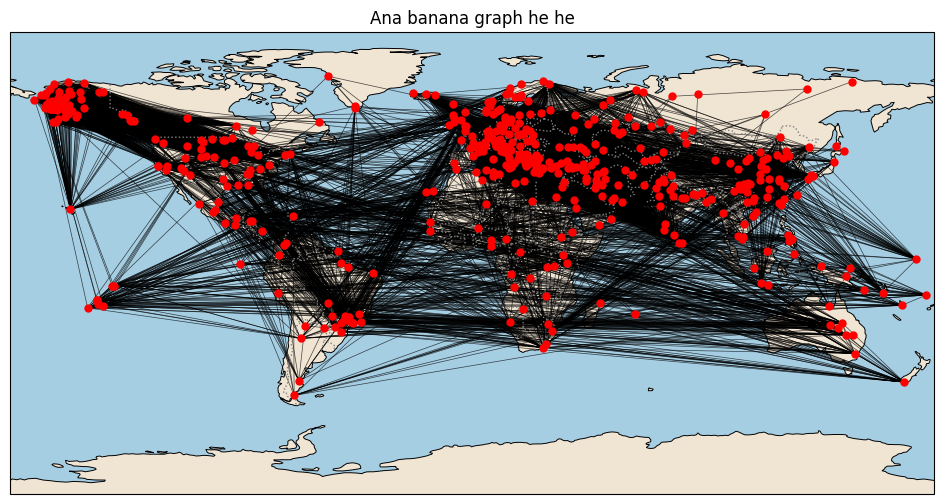

In [96]:
positions = {node: data['coords'] for node, data in G_lda_ana.nodes(data=True)}

# Set up the map using Cartopy
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Enhanced map styling
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Add detailed features
ax.add_feature(cfeature.LAND, facecolor="#f0e4d3")  # Light beige for land
ax.add_feature(cfeature.OCEAN, facecolor="#a6cee3")  # Light blue for oceans
ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=0.7)
ax.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="gray")

# Optionally, add gridlines
#gridlines = ax.gridlines(draw_labels=True, color="gray", linestyle="--", linewidth=0.5)
#gridlines.top_labels = False
#gridlines.right_labels = False

# Draw the graph
nx.draw_networkx_edges(G_lda_ana, positions, ax=ax, edge_color='black', alpha=0.7, width=0.5)
nx.draw_networkx_nodes(G_lda_ana, positions, ax=ax, node_size=25, node_color='red')

# Show the plot
plt.title("Ana banana graph he he")
plt.show()

### Disparity filter

In [39]:
# disparity filter for extracting the multiscale backbone of complex weighted networks

DEBUG = False

def disparity_integral (x, k):
    """
    calculate the definite integral for the PDF in the disparity filter
    """
    assert x != 1.0, "x == 1.0"
    assert k != 1.0, "k == 1.0"
    return ((1.0 - x)**k) / ((k - 1.0) * (x - 1.0))


def get_disparity_significance (norm_weight, degree):
    """
    calculate the significance (alpha) for the disparity filter
    """
    return 1.0 - ((degree - 1.0) * (disparity_integral(norm_weight, degree) - disparity_integral(0.0, degree)))

def report_error (cause_string, logger=None, fatal=False):
    """
    TODO: errors should go to logger, and not be fatal
    """
    etype, value, tb = sys.exc_info()
    error_str = "{} {}".format(cause_string, str(format_exception(etype, value, tb, 3)))

    if logger:
        logger.info(error_str)
    else:
        print(error_str)

    if fatal:
        sys.exit(-1)

def disparity_filter (graph):
    """
    implements a disparity filter, based on multiscale backbone networks
    https://arxiv.org/pdf/0904.2389.pdf
    """
    alpha_measures = []

    for node_id in graph.nodes():
        node = graph.nodes[node_id]
        degree = graph.degree(node_id)
        strength = 0.0

        # Use graph.edges to handle undirected edges
        for id0, id1 in graph.edges(node_id):
            edge = graph[id0][id1]
            strength += edge["weight"]

        node["strength"] = strength

        for id0, id1 in graph.edges(node_id):
            edge = graph[id0][id1]

            norm_weight = edge["weight"] / strength
            edge["norm_weight"] = norm_weight

            if degree > 1:
                try:
                    if norm_weight == 1.0:
                        norm_weight -= 0.0001

                    alpha = get_disparity_significance(norm_weight, degree)
                except AssertionError:
                    report_error("disparity {}".format(repr(node)), fatal=True)

                edge["alpha"] = alpha
                alpha_measures.append(alpha)
            else:
                edge["alpha"] = 0.0

    for id0, id1 in graph.edges():
        edge = graph[id0][id1]
        edge["alpha_ptile"] = percentileofscore(alpha_measures, edge["alpha"]) / 100.0

    return alpha_measures

# related metrics

def calc_quantiles (metrics, num):
    """
    calculate `num` quantiles for the given list
    """
    global DEBUG

    bins = np.linspace(0, 1, num=num, endpoint=True)
    s = pd.Series(metrics)
    q = s.quantile(bins, interpolation="nearest")

    try:
        dig = np.digitize(metrics, q) - 1
    except ValueError as e:
        print("ValueError:", str(e), metrics, s, q, bins)
        sys.exit(-1)

    quantiles = []

    for idx, q_hi in q.items():
        quantiles.append(q_hi)

        if DEBUG:
            print(idx, q_hi)

    return quantiles

def cut_graph (graph, min_alpha_ptile=0.5, min_degree=2):
    """
    apply the disparity filter to cut the given graph
    """
    filtered_set = set([])

    for id0, id1 in graph.edges():
        edge = graph[id0][id1]

        if edge["alpha_ptile"] < min_alpha_ptile:
            filtered_set.add((id0, id1))

    for id0, id1 in filtered_set:
        graph.remove_edge(id0, id1)

    filtered_set = set([])

    for node_id in graph.nodes():
        node = graph.nodes[node_id]

        if graph.degree(node_id) < min_degree:
            filtered_set.add(node_id)

    for node_id in filtered_set:
        graph.remove_node(node_id)

# Graph comperision

In [130]:
import community as community_louvain
from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import euclidean, cityblock, canberra
import colorcet as cc

def detect_communities(graph):
   communities = community_louvain.best_partition(graph)
   num_communities = len(set(communities.values()))
   print(f"Detected {num_communities} communities")
   return communities

def cut_weight(graph, S, T):
    """
    Calculate the cut weight for an undirected, weighted graph.
    Parameters:
        graph: A NetworkX graph (undirected/weighted).
        S: A set of nodes.
        T: The complementary set of nodes.
    Returns:
        Cut weight: Total weight of edges crossing from S to T.
    """
    cut_wt = 0
    for u, v in graph.edges():
        if (u in S and v in T) or (u in T and v in S):
            cut_wt += graph[u][v].get('weight', 1)
    return cut_wt

def cut_distance(graph1, graph2, num_samples=100):
    """
    Approximate the cut distance between two undirected, weighted graphs.
    Parameters:
        graph1, graph2: Two NetworkX graphs with the same node set.
        num_samples: Number of random partitions to approximate the maximum.
    Returns:
        Approximate cut distance between the graphs.
    """
    # Ensure both graphs have the same set of nodes
    if set(graph1.nodes()) != set(graph2.nodes()):
        raise ValueError("Graphs must have the same node set.")

    nodes = list(graph1.nodes())
    n = len(nodes)
    max_diff = 0

    # Generate random bipartitions for approximation
    for _ in range(num_samples):
        np.random.shuffle(nodes)
        split = n // 2
        S = set(nodes[:split])
        T = set(nodes[split:])

        # Calculate cut weights for both graphs
        cut1 = cut_weight(graph1, S, T)
        cut2 = cut_weight(graph2, S, T)

        # Update the maximum difference
        max_diff = max(max_diff, abs(cut1 - cut2))

    # Normalize by the number of nodes for scale invariance
    return max_diff / n

def jaccard_similarity_across_graphs(G1, G2, node):
    # Get the neighbors of the node in both graphs
    neighbors1 = set(G1.neighbors(node))
    neighbors2 = set(G2.neighbors(node))
    
    # Calculate the intersection and union
    intersection = len(neighbors1 & neighbors2)
    union = len(neighbors1 | neighbors2)
    
    # Jaccard similarity formula
    if union == 0:  # Handle case where both sets of neighbors are empty
        return 0.0
    else:
        return intersection / union
    
def jaccard_similarity_edges(graph1, graph2):
   # Get the sets of edges for each graph
   edges1 = set(graph1.edges())
   edges2 = set(graph2.edges())
   
   # Compute intersection and union of the edge sets
   intersection = edges1 & edges2
   union = edges1 | edges2
   
   # Compute Jaccard similarity
   jaccard_sim = len(intersection) / len(union) if len(union) > 0 else 0.0
   
   print(f"Number of edges in Graph 1: {len(edges1)}")
   print(f"Number of edges in Graph 2: {len(edges2)}")
   print(f"Number of common edges: {len(intersection)}")
   print(f"Number of total unique edges: {len(union)}")
   print(f"Jaccard Similarity: {jaccard_sim:.3f}")
   
   return jaccard_sim
    
def weighted_jaccard(g1, g2):
    neighbors1 = set(g1.neighbors(node))
    neighbors2 = set(g2.neighbors(node))
    intersection = neighbors1 & neighbors2
    union = neighbors1 | neighbors2
    mins, maxs = 0, 0
    mins, maxs = 0, 0
    for neighbor in intersection:
        weight1 = g1.get_edge_data(node, neighbor, {}).get('weight', 0)
        weight2 = g2.get_edge_data(node, neighbor, {}).get('weight', 0)
        mins += min(weight1, weight2)

    for neighbor in union:
        weight1 = g1.get_edge_data(node, neighbor, {}).get('weight', 0)
        weight2 = g2.get_edge_data(node, neighbor, {}).get('weight', 0)
        maxs += max(weight1, weight2)
    if maxs == 0:
        return 0
    return mins / maxs

# 1. Compare Nodes
def compare_nodes(graph1, graph2):
    nodes1 = set(graph1.nodes())
    nodes2 = set(graph2.nodes())
    common_nodes = nodes1 & nodes2
    print(f"Nodes in both graphs: {len(common_nodes)}")
    print(f"Nodes only in Graph 1: {len(nodes1 - nodes2)}")
    print(f"Nodes only in Graph 2: {len(nodes2 - nodes1)}")
    return common_nodes

def compute_node_centrality(graph, centrality_type='degree'):
    if centrality_type == 'degree':
        return nx.degree_centrality(graph)
    elif centrality_type == 'closeness':
        return nx.closeness_centrality(graph)
    elif centrality_type == 'betweenness':
        return nx.betweenness_centrality(graph)
    else:
        raise ValueError("Invalid centrality type")

def compare_edge_weights(graph1, graph2):
    common_edges = set(graph1.edges()) & set(graph2.edges())
    
    if len(common_edges) < 2:
        print(f"Not enough common edges to calculate correlation. Found {len(common_edges)} common edges.")
        return None, None
    
    weights1 = np.array([graph1[u][v]['weight'] for u, v in common_edges])
    weights2 = np.array([graph2[u][v]['weight'] for u, v in common_edges])
    
    # Normalize the weights to a range of 0 to 1
    scaler = MinMaxScaler()
    weights1 = scaler.fit_transform(weights1.reshape(-1, 1)).flatten()
    weights2 = scaler.fit_transform(weights2.reshape(-1, 1)).flatten()
    
    # Calculate correlations
    corr_pearson = pearsonr(weights1, weights2)
    corr_spearman = spearmanr(weights1, weights2)
    
    print(f"Edge Weight Correlation (Pearson): {corr_pearson[0]:.3f}")
    print(f"Edge Weight Correlation (Spearman): {corr_spearman[0]:.3f}")
    
    return corr_pearson, corr_spearman

def compute_graph_metrics(graph):
    avg_path_length = nx.average_shortest_path_length(graph) if nx.is_connected(graph) else None
    clustering_coefficient = nx.average_clustering(graph)
    graph_diameter = nx.diameter(graph) if nx.is_connected(graph) else None
    print(f"Average Path Length: {avg_path_length}")
    print(f"Clustering Coefficient: {clustering_coefficient}")
    print(f"Graph Diameter: {graph_diameter}")
    
def compare_weighted_graphs(graph1, graph2):
    # Get the union of edges from both graphs
    edges_union = set(graph1.edges()) | set(graph2.edges())

    # Normalize weights across both graphs
    all_weights = []
    for edge in edges_union:
        w1 = graph1[edge[0]][edge[1]].get('weight', 0) if graph1.has_edge(*edge) else 0
        w2 = graph2[edge[0]][edge[1]].get('weight', 0) if graph2.has_edge(*edge) else 0
        all_weights.append((w1, w2))

    # Convert weights to numpy array for normalization
    weights_array = np.array(all_weights)
    scaler = MinMaxScaler()
    normalized_weights = scaler.fit_transform(weights_array)

    # Split normalized weights into two arrays
    weights1 = normalized_weights[:, 0]
    weights2 = normalized_weights[:, 1]

    # Calculate distances
    euclidean_dist = euclidean(weights1, weights2)
    manhattan_dist = cityblock(weights1, weights2)
    canberra_dist = canberra(weights1, weights2)

    # Calculate Jaccard distance based on edge presence
    edges_graph1 = set(graph1.edges())
    edges_graph2 = set(graph2.edges())
    intersection = len(edges_graph1 & edges_graph2)
    union = len(edges_graph1 | edges_graph2)
    jaccard_dist = 1 - intersection / union if union > 0 else 1  # 1 if no union

    # Print results
    print(f"Euclidean Distance (EUC): {euclidean_dist:.4f}")
    print(f"Manhattan Distance (MAN): {manhattan_dist:.4f}")
    print(f"Canberra Distance (CAN): {canberra_dist:.4f}")
    print(f"Jaccard Distance (JAC): {jaccard_dist:.4f}")
    
def graph_vis_comparison(graph1, graph2, community1, community2):

    positions = {node: data['coords'] for node, data in graph1.nodes(data=True)}
    positions = positions | {node: data['coords'] for node, data in graph2.nodes(data=True)}

    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})

    # Generate Glasbey palette
    num_communities1 = len(set(community1.values()))
    num_communities2 = len(set(community2.values()))
    num_colors = max(num_communities1, num_communities2)
    glasbey_palette = cc.glasbey[:num_colors]

    # Enhanced map styling for the first graph
    ax1.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
    ax1.add_feature(cfeature.LAND, facecolor="#f0e4d3")
    ax1.add_feature(cfeature.OCEAN, facecolor="#a6cee3")
    ax1.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=0.7)
    ax1.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="gray")
    ax1.add_feature(cfeature.LAKES, facecolor="#a6cee3", edgecolor="blue", alpha=0.5)
    ax1.add_feature(cfeature.RIVERS, edgecolor="blue", alpha=0.7)

    # Draw the first graph
    for i, community in enumerate(set(community1.values())):
        nodes = [node for node in community1 if community1[node] == community]
        nx.draw_networkx_nodes(graph1, pos=positions, nodelist=nodes, node_color=[glasbey_palette[i]], node_size=20, ax=ax1)
    ax1.set_title("Graph 1")

    # Enhanced map styling for the second graph
    ax2.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
    ax2.add_feature(cfeature.LAND, facecolor="#f0e4d3")
    ax2.add_feature(cfeature.OCEAN, facecolor="#a6cee3")
    ax2.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=0.7)
    ax2.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="gray")

    # Draw the second graph
    for i, community in enumerate(set(community2.values())):
        nodes = [node for node in community2 if community2[node] == community]
        nx.draw_networkx_nodes(graph2, pos=positions, nodelist=nodes, node_color=[glasbey_palette[i]], node_size=20, ax=ax2)

    ax2.set_title("Graph 2")

    plt.show()

### Detect Communities

In [131]:

node_attributes = dict(G_lda_ana.nodes(data=True))
print("Node Attributes:", node_attributes)

Node Attributes: {'Krasnodar': {'coords': (np.float64(39.17050171), np.float64(45.03469849))}, 'St. Petersburg': {'coords': (np.float64(30.26250076), np.float64(59.8003006))}, 'Omsk': {'coords': (np.float64(73.3105011), np.float64(54.96699905))}, 'Yekaterinburg': {'coords': (np.float64(60.80270004), np.float64(56.74309921))}, 'Khudzhand': {'coords': (np.float64(69.69470215), np.float64(40.2154007))}, 'Astrakhan': {'coords': (np.float64(48.00630188), np.float64(46.28329849))}, 'Antalya': {'coords': (np.float64(30.800501), np.float64(36.898701))}, 'Sharjah': {'coords': (np.float64(55.51720047), np.float64(25.32859993))}, 'Fergana': {'coords': (np.float64(71.74500275), np.float64(40.35879898))}, 'Samarkand': {'coords': (np.float64(66.9838028), np.float64(39.70050049))}, 'Ufa': {'coords': (np.float64(55.87440109), np.float64(54.55749893))}, 'Bishkek': {'coords': (np.float64(74.4776001), np.float64(43.06129837))}, 'Mineralnye Vody': {'coords': (np.float64(43.08190155), np.float64(44.2251014

In [132]:
print("Communities in Airline Graph:")
communities_airlines = detect_communities(G_flights_sub)

print("Communities in Airline Graph isolated:")
communities_airlines_isloated = detect_communities(G_flights_sub_isloated)

print("Communities in Similarity Graph INES:")
communities_similarity_ines = detect_communities(G_hist)

print("Communities in Similarity Graph ANA:")
communities_similarity_ana = detect_communities(G_lda_ana)

Communities in Airline Graph:
Detected 95 communities
Communities in Airline Graph isolated:
Detected 35 communities
Communities in Similarity Graph INES:
Detected 56 communities
Communities in Similarity Graph ANA:
Detected 51 communities


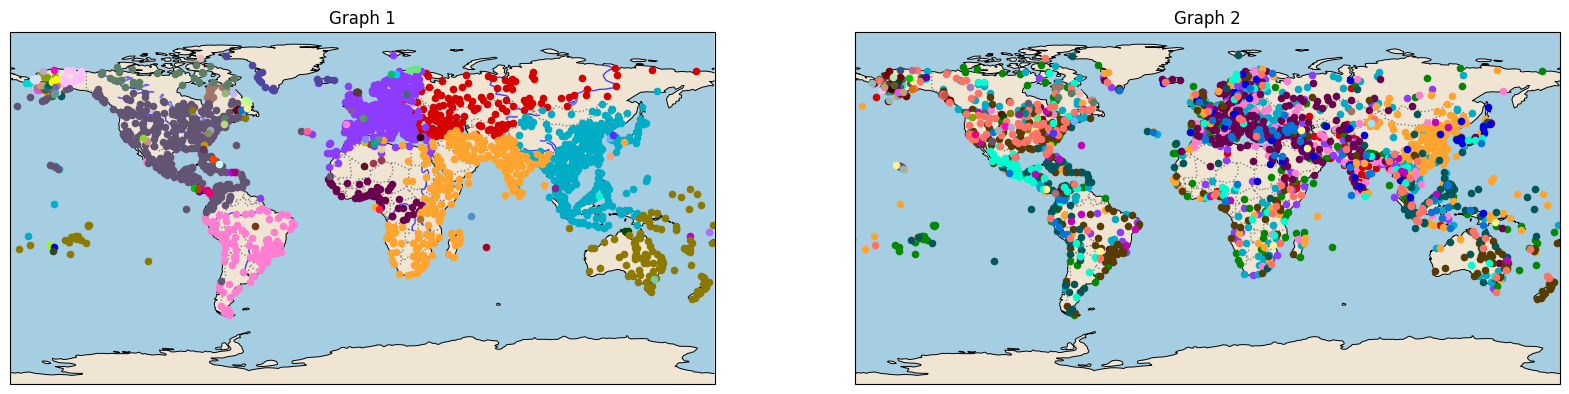

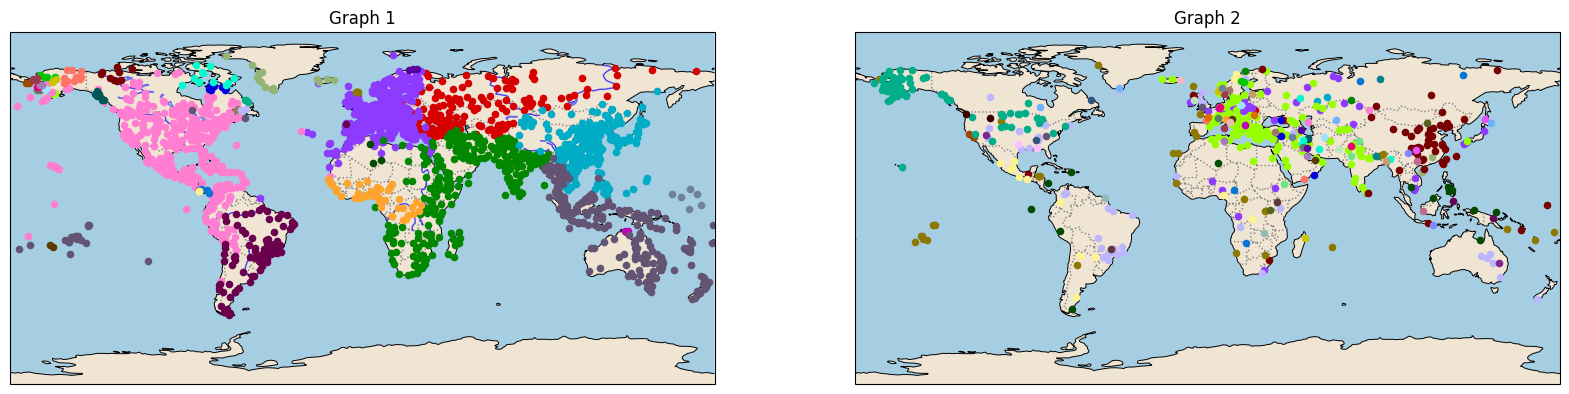

In [133]:
import colorcet as cc


graph_vis_comparison(G_flights_sub, G_hist, communities_airlines, communities_similarity_ines)
graph_vis_comparison(G_flights_sub_isloated, G_lda_ana, communities_airlines_isloated, communities_similarity_ana)

In [ ]:
# def get_community_node_counts(community):
#     community_sizes = Counter(community.values())
#     community_node_counts = {community: [] for community in community_sizes.keys()}
#     for node, community_id in community.items():
#         community_node_counts[community_id].append(node)
#     return community_node_counts

# def get_top_communities(community, num_communities):
#     community_sizes = get_community_node_counts(community)
#     top_communities = community_sizes.most_common(num_communities)
#     return top_communities

# top_communities_airlines = get_top_communities(communities_airlines, 5)
# print("Top 5 communities in the Airline Graph:", top_communities_airlines)
# top_communities_similarity = get_top_communities(communities_similarity_ines, 5)
# print("Top 5 communities in the Similarity Graph:", top_communities_similarity)

AttributeError: 'dict' object has no attribute 'most_common'

In [153]:
#get average node count for each community
community_node_counts_airlines = get_community_node_counts(communities_airlines)
mean_airlines = sum(len(nodes) for nodes in community_node_counts_airlines.values()) / len(community_node_counts_airlines)
print("Average Community Node Count in the Airline Graph:", mean_airlines)

community_node_counts_similarity = get_community_node_counts(communities_similarity)
mean_similarity = sum(len(nodes) for nodes in community_node_counts_similarity.values()) / len(community_node_counts_similarity)
print("Average Community Node Count in the Similarity Graph:", mean_similarity)

Average Community Node Count in the Airline Graph: 21.46315789473684
Average Community Node Count in the Similarity Graph: 9.568627450980392


In [ ]:
# #print word cloud for top 2 communities
# from wordcloud import WordCloud
# from PIL import Image, ImageDraw

# size = 500  # Define the size of the mask
# circle = Image.new('L', (size, size), 0)  # Create a black image
# draw = ImageDraw.Draw(circle)
# draw.ellipse((0, 0, size, size), fill=255)  # Draw a white circle
# circle_mask = np.array(circle)
# inverted_mask = np.invert(circle_mask)  # Invert black and white areas


# def plot_word_clouds(community_node_counts, graph):
#     for i, (community_id, nodes) in enumerate(community_node_counts.items(), 1):
#         top_words = []
#         for node in nodes:
#             top_words.extend(graph.nodes[node]['top_words'])
#         top_words = ' '.join(top_words)
#         wordcloud = WordCloud(width=800, height=400, background_color='white', mask=inverted_mask, contour_color='black', contour_width=2).generate(top_words)
        
#         plt.figure(figsize=(10, 5))
#         plt.imshow(wordcloud, interpolation='bilinear')
#         plt.axis('off')
#         plt.title(f"Word Cloud for Community {community_id}")
#         plt.show()



# similarity_top_2_communities = {community_id: nodes for community_id, nodes in community_node_counts_similarity.items() if community_id in [top[0] for top in top_communities_similarity[:2]]}
# plot_word_clouds(similarity_top_2_communities, G_hist)

NameError: name 'top_communities_similarity' is not defined

## Cut Distance
make no sence for ana graph as there are not the same nodes

In [135]:
#implement Cut Distance
distance = cut_distance(G_flights_sub, G_hist, num_samples=1000)
# distance_ana = cut_distance(G_flights_sub_isloated, G_lda_ana, num_samples=1000)

print(f"Approximate Cut Distance: {distance}")
# print(f"Approximate Cut Distance: {distance_ana}")


Approximate Cut Distance: 7.800942710524556


## Weighted Jaccard Similarity

 $$text{Weighted Jaccard Similarity} = \frac{\sum_{n \in \text{Intersection}} \min(\text{weight1}(n), \text{weight2}(n))}{\sum_{n \in \text{Union}} \max(\text{weight1}(n), \text{weight2}(n))} $$

In [137]:
# Initialize dictionary to store similarities
similarity = {}

# Calculate similarity for all nodes in G1
for node in G_flights_sub.nodes():
    similarity[node] = weighted_jaccard(G_flights_sub, G_hist)

#Get average similarity
print("Mean :", np.mean(list(similarity.values())))

Mean : 0.01551536752284009


## DeltaCon

In [64]:
import random

from scipy.sparse import dok_matrix
from scipy.sparse import csc_matrix
from scipy.sparse import identity
from scipy.sparse import diags
from numpy import concatenate
from numpy import square
from numpy import array
from numpy import trace
from numpy import amax
from math import sqrt

def GenAdjacentMatrix(graph):
    '''
    Get adjacent matrix from file
    '''
    #data = pd.read_table(f, delimiter=' ', header=None)
    #i = data[0]
    #j = data[1]
    #size = max([max(i), max(j)])
    size = graph.number_of_nodes()
    #adjacent = dok_matrix((size, size), dtype=np.int)
    adjacent = dok_matrix((size, size), dtype=int)
    # for k in range(len(i)):
    #     adjacent[i[k] - 1, j[k] - 1] = 1
    #     adjacent[j[k] - 1, i[k] - 1] = 1
    # for k in range(size):
    #     adjacent[k, k] = 0
    node_to_index = {node: idx for idx, node in enumerate(graph.nodes())}

    for edge in graph.edges():
        i = node_to_index[edge[0]]  # Convert the first node (city) to an index
        j = node_to_index[edge[1]]
        adjacent[i, j] = 1
        adjacent[j, i] = 1

    return adjacent

def Partition(num, size):
    '''
    Randomly divide size nodes into num groups
    '''
    partitions = {}
    nodes = [x for x in range(1, size + 1)]
    group_size = int(size / num)
    for i in range(num - 1):
        partitions[i] = []
        for j in range(group_size):
            node = random.choice(nodes)
            nodes.remove(node)
            partitions[i].append(node)

    # The last partition gets the rest of the nodes
    partitions[num - 1] = nodes[:]

    return partitions

def Partition2e(partitions, size):
    '''
    Change partition into e vector
    size is the dimension n
    '''
    e = {}
    for p in partitions:
        e[p] = []
        for i in range(1, size + 1):
            if i in partitions[p]:
                e[p].append(1.0)
            else:
                e[p].append(0.0)
    return e

def InverseMatrix(A, partitions):
    '''
    Use Fast Belief Propagation
    CITATION: Danai Koutra, Tai-You Ke, U. Kang, Duen Horng Chau, Hsing-Kuo
    Kenneth Pao, Christos Faloutsos
    Unifying Guilt-by-Association Approaches
    return [I+a*D-c*A]^-1
    '''
    num = len(partitions)  # The number of partitions

    I = identity(A.shape[0])  # Identity matrix
    D = diags(sum(A).toarray(), [0])  # Diagonal degree matrix

    c1 = trace(D.toarray()) + 2
    c2 = trace(square(D).toarray()) - 1
    h_h = sqrt((-c1 + sqrt(c1 * c1 + 4 * c2)) / (8 * c2))

    a = 4 * h_h * h_h / (1 - 4 * h_h * h_h)
    c = 2 * h_h / (1 - 4 * h_h * h_h)

    M = c * A - a * D
    for i in range(num):
        inv = array([partitions[i][:]]).T
        mat = array([partitions[i][:]]).T
        power = 1
        while amax(M.toarray()) > 10**(-9) and power < 10:
            mat = M.dot(mat)
            inv += mat
            power += 1
        if i == 0:
            MatrixR = inv
        else:
            MatrixR = concatenate((MatrixR, array(inv)), axis=1)

    S = csc_matrix(MatrixR)
    return S

def Similarity(A1, A2, g):
    '''
    Use DeltaCon to compute similarity
    CITATION: Danai Koutra, Joshua T. Vogelstein, Christos Faloutsos
    DELTACON: A Principled Massive-Graph Similarity Function
    g is the number of partitions
    '''
    size = A1.shape[0]

    partitions = Partition(g, size)
    e = Partition2e(partitions, size)

    S1 = InverseMatrix(A1, e)
    S2 = InverseMatrix(A2, e)

    d = 0
    for i in range(size):
        for j in range(g):
            d += (sqrt(S1[i, j]) - sqrt(S2[i, j]))**2
    d = sqrt(d)
    sim = 1 / (1 + d)
    return sim

def DeltaCon(A1, A2, g):
    # Compute average similarity
    Iteration = 10
    average = 0.0
    for i in range(Iteration):
        average += Similarity(A1, A2, g)
    average /= Iteration
    return average


In [65]:
#perform deltacon
A1 = GenAdjacentMatrix(G_flights_sub)
A2 = GenAdjacentMatrix(G_hist)
similarity = DeltaCon(A1, A2, 10)
print(f"DeltaCon Similarity: {similarity:.3f}")

DeltaCon Similarity: 0.065


### Graph comparison ana

In [139]:
import statistics

node_sim = {}

for flight_node in G_flights_sub_isloated.nodes():
   if flight_node in G_lda_ana.nodes():
      # calcualte similarty
      sim = jaccard_similarity_across_graphs(G_flights_sub_isloated, G_lda_ana, flight_node)
      if sim == 1:
         print("node", flight_node)
         print("flight neighbours",list(G_flights_sub_isloated.neighbors(flight_node)))
         print("similarty neighbours",list(G_lda_ana.neighbors(flight_node)))
      # save the similarty
      node_sim[flight_node] = sim
      
similarites = list(node_sim.values())

# Calculating various statistics
mean = statistics.mean(similarites)
median = statistics.median(similarites)
stdev = statistics.stdev(similarites)
variance = statistics.variance(similarites)
minimum = min(similarites)
maximum = max(similarites)
range_value = maximum - minimum

# Printing the results
print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Standard Deviation: {stdev}")
print(f"Variance: {variance}")
print(f"Minimum: {minimum}")
print(f"Maximum: {maximum}")
print(f"Range: {range_value}")

Mean: 0.013149600304549562
Median: 0.0
Standard Deviation: 0.026702330341170494
Variance: 0.0007130144456489944
Minimum: 0.0
Maximum: 0.14754098360655737
Range: 0.14754098360655737


In [150]:
common_nodes = compare_nodes(G_flights_sub_isloated, G_lda_ana)

centrality_airlines = compute_node_centrality(G_flights_sub_isloated)
centrality_similarity = compute_node_centrality(G_lda_ana)
airlines_values = []
similarity_values = []
for city in centrality_airlines.keys():
    if city in centrality_similarity.keys():
        airlines_values.append(centrality_airlines[city])
        similarity_values.append(centrality_similarity[city])    
# Compare centralities (example: Pearson correlation)
airlines_values = np.array(airlines_values)
similarity_values = np.array(similarity_values)
correlation = pearsonr(airlines_values, similarity_values)
print(f"Centrality Correlation (Pearson): {correlation[0]:.3f}")

compare_edge_weights(G_flights_sub_isloated, G_lda_ana)

print("Metrics for Airline Graph:")
compute_graph_metrics(G_flights_sub_isloated)

print("Metrics for Similarity Graph:")
compute_graph_metrics(G_lda_ana)

jaccard_similarity_edges(G_flights_sub_isloated, G_lda_ana)

compare_weighted_graphs(G_flights_sub_isloated, G_lda_ana)

Nodes in both graphs: 465
Nodes only in Graph 1: 1511
Nodes only in Graph 2: 23
Centrality Correlation (Pearson): 0.006
Edge Weight Correlation (Pearson): 0.036
Edge Weight Correlation (Spearman): 0.131
Metrics for Airline Graph:
Average Path Length: None
Clustering Coefficient: 0.5002152898528319
Graph Diameter: None
Metrics for Similarity Graph:
Average Path Length: None
Clustering Coefficient: 0.7960515813646907
Graph Diameter: None
Number of edges in Graph 1: 12557
Number of edges in Graph 2: 12557
Number of common edges: 262
Number of total unique edges: 24852
Jaccard Similarity: 0.011
Euclidean Distance (EUC): 112.5002
Manhattan Distance (MAN): 13540.5464
Canberra Distance (CAN): 24817.8865
Jaccard Distance (JAC): 0.9895


## How to use diperity filer on the graph DO NOT RUN IT IF YOU WANT TO KEEP YOUR SANITY

In [ ]:
G_hist_disparity = G_hist.copy()
G_text_disparity = G_flights_sub.copy()

alpha_measures_hist= disparity_filter(G_hist_disparity)
print("Alpha measures calculated:", alpha_measures_hist)

alpha_measures_text= disparity_filter(G_text_disparity)
print("Alpha measures calculated:", alpha_measures_text)

quantiles_hist = calc_quantiles(alpha_measures_hist, num = 10)
quantiles_text = calc_quantiles(alpha_measures_text, num = 10)

# Determine alpha cutoff (median, 30th percentile)
min_alpha_ptile = 0.3
alpha_cutoff_hist = quantiles_hist[int(min_alpha_ptile * (len(quantiles_hist) - 1))]
print(f"Using alpha cutoff at {min_alpha_ptile * 100}% percentile: {alpha_cutoff_hist}")
alpha_cutoff_text = quantiles_text[int(min_alpha_ptile * (len(quantiles_text) - 1))]
print(f"Using alpha cutoff at {min_alpha_ptile * 100}% percentile: {alpha_cutoff_text}")

# Filter the graph based on the cutoff
cut_graph(G_hist_disparity, min_alpha_ptile=min_alpha_ptile)
cut_graph(G_text_disparity, min_alpha_ptile=min_alpha_ptile)

print(f"There were {len(G_hist.nodes())} nodes and {len(G_hist.edges())} edges in un-filtered graph")
print(f"There are currently {len(G_hist_disparity.nodes())} nodes and {len(G_hist_disparity.edges())} edges in filtered graph")

print(f"There were {len(G_flights_sub.nodes())} nodes and {len(G_flights_sub.edges())} edges in un-filtered graph")
print(f"There are currently {len(G_text_disparity.nodes())} nodes and {len(G_text_disparity.edges())} edges in filtered graph")

Alpha measures calculated: [np.float64(0.3356644678298887), np.float64(0.3357500775315869), np.float64(0.3463807630231577), np.float64(0.35221972277304436), np.float64(0.3528009998227528), np.float64(0.3532242085732116), np.float64(0.3532614331253229), np.float64(0.3536639422990844), np.float64(0.35464750570879133), np.float64(0.3546925014373524), np.float64(0.3549344684584388), np.float64(0.355021587178854), np.float64(0.3561695074782997), np.float64(0.41765848695454444), np.float64(0.3982018711017421), np.float64(0.3317129962825395), np.float64(0.3327847631744538), np.float64(0.33468300900398895), np.float64(0.33832829353310623), np.float64(0.34113521121921886), np.float64(0.3415725616585976), np.float64(0.34778337154308225), np.float64(0.34802409717058014), np.float64(0.3485893279799558), np.float64(0.3496998496022625), np.float64(0.37197287320545536), np.float64(0.4498342281674328), np.float64(0.34916789853117836), np.float64(0.38456952699458313), np.float64(0.3560374677566862), np